# Term frequency analysis of build logs

This notebook applies term frequency analysis to build logs in order to determine if the contents of build logs can provide additional insight into job execution. 

For "traditional" log analysis, a *Bag of Words (BoW)* approach is usually not a good option. BoW completely ignores things like the order in which words (or messages) appear, while normally the order within logs is quite significant.

However, for CI logs we can exploit characteristics that "traditional" logs don't usually have: they have a beginning and an end, so we can treat them as documents; and we have multiple occurrences of each "document" (i.e. the build log for each job run).

Here we are going to attempt to clusterize job runs using the frequency of terms that appear in their build logs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from datetime import datetime, timezone
from matplotlib import cm
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time


# Some settings for the notebook
pd.options.display.float_format = "{:.2f}".format
random.seed(1)
sns.set(rc={"figure.figsize": (15, 5)})
colormap = (
    cm.brg
)  # see https://matplotlib.org/stable/tutorials/colors/colormaps.html for alternatives

## Loading the data

We start by loading the metadata for a specific CI job. This data is dowloaded and saved by the [initial build log EDA](./build_log_EDA.ipynb) notebook.

We also define a couple of helper functions to help us find a particular (already dowloaded) build log and to point to the build's prow status page, as well as a small function to prepare our data.

In [2]:
# Note: periodic jobs only (see FIXME in class Builds)
job_name = "periodic-ci-openshift-release-master-ci-4.8-e2e-gcp"

logs_path = "../../../../data/raw/gcs/build-logs/"  # local cache of build log files
metadata_path = "../../../../data/raw/gcs/build-metadata/"  # path to saved metadata
metadata_file_name = os.path.join(metadata_path, f"{job_name}_build-logs.csv")


def log_path_for(build_id):
    return os.path.join(logs_path, f"{build_id}.txt")


def prow_url_for(build_id):
    project = "origin-ci-test"
    # FIXME: this prefix is only for periodic jobs
    job_prefix = f"logs/{job_name}/"
    return f"https://prow.ci.openshift.org/view/gcs/{project}/{job_prefix}{build_id}"


def clean_df(df):
    """Polishes the metadata DataFrame"""
    build_errors = df[df["result"] == "error"].index
    df.drop(build_errors, inplace=True)  # Remove builds that erroed (prow error)
    df["duration"] = df["end"] - df["start"]  # From timestamps to job duration
    df["success"] = df["result"] == "SUCCESS"  # A boolean version of the result
    return df


print("Reading metadata from", metadata_file_name)
df = pd.read_csv(metadata_file_name, index_col=0)
df = clean_df(df)
df

Reading metadata from ../../../../data/raw/gcs/build-metadata/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp_build-logs.csv


,result,size,start,end,duration,success
1368338379971760128,FAILURE,5846974,1615072270,1615076702,4432,False
1372646746210963456,SUCCESS,9785,1616099471,1616104582,5111,True
1375709011390763008,SUCCESS,9962,1616829565,1616834000,4435,True
1380281977160077312,SUCCESS,3841,1617919845,1617929494,9649,True
1385025333723402240,SUCCESS,3868,1619050750,1619056186,5436,True
...,...,...,...,...,...,...
1381826019446493184,SUCCESS,3837,1618287973,1618292751,4778,True
1371068681810874368,SUCCESS,9782,1615723223,1615728027,4804,True
1377999575511470080,SUCCESS,12329,1617375678,1617380533,4855,True
1369750447904002048,FAILURE,6467331,1615408933,1615413675,4742,False


### A view of our job/log metadata

The data we work with contains only the following information about each job build:
  - The *result* of the build (wether it was successful or not). The metadata has a label and we also compute a boolean for it.
  - The build *start* and *end* timestamps. We compute the *duration* from that.
  - The *size* (lenght) in bytes of the `build-log`.

We saw in the initial exploration that with just this information, without even looking at the contents of the logs, we can have a good idea of how/if the build failed:

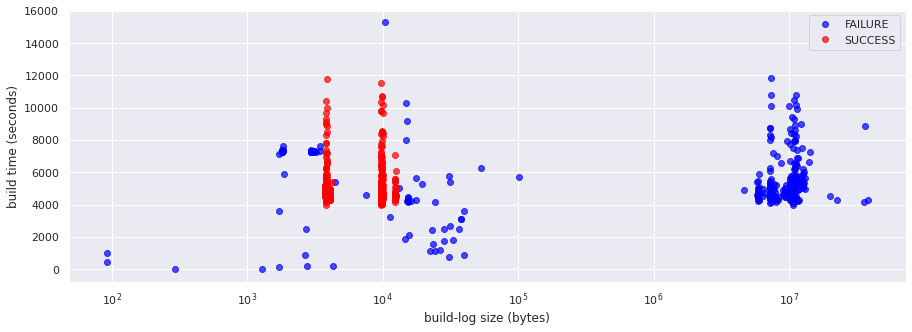

In [3]:
def plot_clusters():
    clusters = df.cluster.unique()
    for i, cluster in enumerate(sorted(clusters)):
        color = colormap(float(i) / len(clusters))
        plt.plot(
            "size",
            "duration",
            "o",
            data=df[df.cluster == cluster],
            color=color,
            alpha=0.7,
            label=cluster,
        )
    plt.xscale("log")
    plt.xlabel("build-log size (bytes)")
    plt.ylabel("build time (seconds)")
    plt.legend()
    plt.show()


df = df.assign(cluster=df.result)
plot_clusters()

This sample job shows a pattern that is common across various jobs that have been observed:

- We see that successful runs have an almost constant and relatively small build log size. We noted in the [initial build log EDA](./build_log_EDA.ipynb) notebook that the two main log size groups visible in successful runs is due to [a change in how logs are formatted](https://github.com/openshift/ci-tools/pull/1836).
- Some run failures have big log sizes. These are the ones that incorporate the full output of test suite (successful runs do not include that output).
- Some runs fail in the preparation steps, before tests can actually be run. Hence, all runs that run for less than a certain time threshold (the time it takes for preparation steps to complete) result in a failure.

Based on that, we could probably have a classifier for pass/fail with decent accuracy just by looking at the log size and execution time. And, of course, we can just look at the result to see if a run fails or succeeds.

Can the contents of the logs help us group job runs according to different types of success / failure?

Or, in other words, can we extract additional value/information about what happened during the build by looking at build log contents?

Let's try.


## Term frequency analysis

In [4]:
# Get a list of paths to the local copy of each build log
build_logs = []
for build_id in df.index:
    build_logs.append(log_path_for(build_id))

As mentioned in the introduction, we are going to apply a technique which is not commonly applied to log data: [term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) analysis; the idea here is that we can exploit the peculiarities of CI log data (vs traditional log data).

Before we begin, a key question we must answer is: what is a *term* for us?

If we were working with natural language text, typically we would identify terms (*tokens*) by any separation between words, including spacing and punctuation. Logs, however, often contain terms that include some sort of punctuation character that should not be used to separate them. For example, `/file/paths/like/this` or `some.component.like.this` or maybe `something-with:tags`. We probably want to consider these types of terms as a single unit (token).

On the other hand, it might be counter-productive to keep all punctuation/separators in:

- Some Kubernetes resource names contain generated parts that look very similar to non-generated content. For example, a Deployment called `sample-deployment-3` can produce a Pod called `sample-deployment-3-7fdfd97c84-7rj8b`. The name of the deployemt is probably relevant, while the name of the Pod is probably not.
- Some other name parts might refer to a specific version, like `v0-5-0-o79ew2-1fdt39x15`; these look like generated parts but are as interesting as non-generated ones.

The criteria followed below (by default) aims at a compromise, taking advantadge of the fact that we have multiple documents (log files):

- Do not separate by some punctuation like `.` or `/`
- Discard tokens that appear in less than 5% of our documents

This should help us e.g. keep a Deployment name as a term and discard a specific Pod name.

Besides that, the minimum requirement that we impose on tokens is:

- A minimum lenght of 2 alphanumerical characters (or punctuation as mentioned)
- Not starting with a number

Note that by not allowing numbers as the first character of a token we are discarding all sorts of terms: dates, times, IP addresses, all plain numbers, duration (`42s`), size (`28k`), etc.

Some experimentation with various options suggests that this particular pattern leads to best results. For alternative versions, see the comments below (and note that `token_pattern` is optional and can be left out completely, to use a default tokenizer that does not allow any punctuation character within tems).

One option that has not been explored is to separate tokens more aggresively (e.g. with the default tokenizer) and then work with n-grams. Note that most of the names/identifiers that are likely relevant to keep would not be captured by bigrams or even trigrams.

In [5]:
# Our default token pattern matches tokens which:
# - are at least 2-chars long
# - start with a letter
# - can contain letters, numbers, or any of: _ - / .
token_pattern = r"\b[a-z][a-z0-9_/\.-]+\b"

# Alternative token patterns
# token_pattern = r"\b[a-z][a-z0-9_/\.:-]+\b"  # keep slahs/dash-colons:together
# token_pattern = r"\b[a-z][a-z0-9_/\.:]+\b"  # separate terms-like-this-one, keep colons
# token_pattern = r"\b[a-z][a-z0-9_/\.]+\b"  # separate dashes and colons
# token_pattern = r"\b[a-z][a-z0-9_\.:]+\b"  # separate terms/like-this-one
# token_pattern = r"\b[a-z][a-z0-9_\.]+\b"  # separate slash, dash and colon
# token_pattern = r"\b\w[a-z0-9_/\.-]+\b"  # allow numbers

t0 = time()
vectorizer = TfidfVectorizer(
    input="filename",
    min_df=0.03,
    # stop_words='english',  # remove common english words
    token_pattern=token_pattern,
)

tfidf = vectorizer.fit_transform(build_logs)

print(f"Done in {time()-t0:.2f} seconds")
print(f"TF-IDF matrix: {tfidf.shape[0]} documents x {tfidf.shape[1]} terms")

Done in 82.08 seconds
TF-IDF matrix: 837 documents x 4339 terms


The resulting vocabulary (the terms we work with) with the default token pattern is in the order of ~4000 terms. 

If we allow numbers, the vocabulary can easily increase by over an order of magnitude.

Let's look at a sample of the resulting vocabulary:

In [6]:
terms = vectorizer.get_feature_names()

print(" | ".join(random.choices(terms, k=100)))

container/failure-2 | ss2-2 | request/limit | e2e-gcp-gather-audit-logs | nodeauthenticator | mappings | port | router_metrics_type | client.timeout | approved | similar | like | report | accept | main.main | recreatedeployment | deprecated | v1.20.0/test/e2e/framework/framework.go | testsimpleimagechangebuildtriggerfromimagestreamtagcustom | apps/v1/daemonset/openshift-multus/multus/initcontainer/routeoverride-cni/request | apiversion | orphans | us-east1 | incompatible | deployment/idle-test | kubernetes.io/gce-pd | apps/v1/daemonset/openshift-multus/multus/initcontainer/cni-plugins/request | deployment/test-rollover-deployment | loading | nodeconformance | dhe-rsa-aes256-gcm-sha384 | detach | deployment/sample-apiserver-deployment | minute | executing | answer | single-container | persistentvolumeclaim/snapshot-test-pvc | pod/testpod-pclass6 | csi-hostpath-attacher | windows | sti | container | github.com/openshift/origin/pkg/test/ginkgo | recreatedeployment | reason/rolloutinprogre

We now have each *document* (i.e. each `build-log` file) represented by a vector of a few thousand dimensions (i.e. one per term in the vocabulary).

## Clustering

Let's now try to apply a clustering algorithm to that group of vectors.

Here we will try k-means.

In order to get an idea of the best number of clusters ($k$) we should try to build (i.e. how many groups or types of build logs we have) we calculate a few metrics on each number of clusters to help us identify the best $k$ for our data set:

- plot the sum of squared distances between samples and cluster centroids to use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering))
- Calinski-Harabas index
- Davies-Bouldin index
- Average Silhouette score

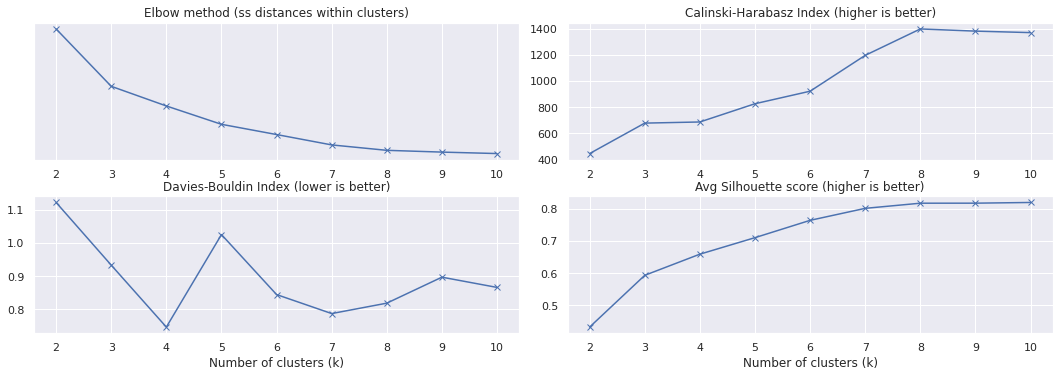

In [7]:
def kmeans_metrics(x, kmax=11):
    ss = []  # Sum of squared distances of samples to their closest cluster center
    ch = []  # Caliski-Harabasz index
    sc = []  # Silhouette Coefficient
    db = []  # Davies-Bouldin index

    k_range = range(2, kmax)
    x_arr = x.toarray()  # several metrics don't work with sparse arrays
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(x_arr)
        labels = kmeans.labels_
        ss.append(kmeans.inertia_)
        ch.append(metrics.calinski_harabasz_score(x_arr, labels))
        sc.append(metrics.silhouette_score(x_arr, labels))
        db.append(metrics.davies_bouldin_score(x_arr, labels))

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.tight_layout()

    ax1.plot(k_range, ss, "x-")
    ax1.set_title("Elbow method (ss distances within clusters)")
    # Not interested in the distance values, only the shape of the plot:
    ax1.set_yticks([])

    ax2.set_title("Calinski-Harabasz Index (higher is better)")
    ax2.plot(k_range, ch, "x-")

    ax3.set_title("Davies-Bouldin Index (lower is better)")
    ax3.plot(k_range, db, "x-")
    ax3.set_xlabel("Number of clusters (k)")

    ax4.set_title("Avg Silhouette score (higher is better)")
    ax4.plot(k_range, sc, "x-")
    ax4.set_xlabel("Number of clusters (k)")

    plt.show()


kmeans_metrics(tfidf)

The elbow plot suggests that for our data we should pick $k = 3$:

In [8]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(tfidf)
df = df.assign(cluster=kmeans.labels_)

With the clusters created by k-means, let's take a look at which are the most common terms in each cluster. This should hopefully give us an idea of what type of build belogs to each group:

In [9]:
def cluster_terms(topn=10):
    """Print the top tokens for each cluster"""
    terms = vectorizer.get_feature_names()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(k):
        print("Cluster %d:" % i, end="")
        for ind in order_centroids[i, :topn]:
            print(" %s" % terms[ind], end="")
        print()


def describe_clusters():
    x = tfidf.toarray()
    print(k, "clusters with the following metrics:")
    print(
        f"  - Silhouette coefficient: {metrics.silhouette_score(tfidf, kmeans.labels_):.2f}"
    )
    print(
        f"  - Calinski-Harabasz index: {metrics.calinski_harabasz_score(x, kmeans.labels_):.2f}"
    )
    print(
        f"  - Davies-Bouldin index: {metrics.davies_bouldin_score(x, kmeans.labels_):.2f}"
    )
    print("A list of the most common terms in each cluster:")
    cluster_terms(9)


describe_clusters()

3 clusters with the following metrics:
  - Silhouette coefficient: 0.59
  - Calinski-Harabasz index: 678.42
  - Davies-Bouldin index: 0.93
A list of the most common terms in each cluster:
Cluster 0: apr suite mar openshift/conformance/parallel k8s volumes should driver sig-storage
Cluster 1: pod completed successfully container in place-entrypoint cp-entrypoint-wrapper sidecar executing
Cluster 2: step e2e running after succeeded release for latest to


Looking at that list of most popular terms per cluster we can have an intuition that one of the clusters (cluster *0*) most likely corresponds to builds that managed to run a test suite where some test(s) failed. We know from the [initial build log exploration](./build_log_EDA.ipynb) that the build log only shows test logs when there are test failures; in that cluster we see terms like *suite*, references to *conformance* test, or references to a *sig* group that are present in test logs.

However, for the other two clusters it is hard to say what makes them different. In particular, it seems a bit strange that both show terms related to *success* in their top list of terms.

Let's plot these clusters against the build duration and size to compare with our [initial visualization](#A-view-of-our-log-metadata), to see where they match:

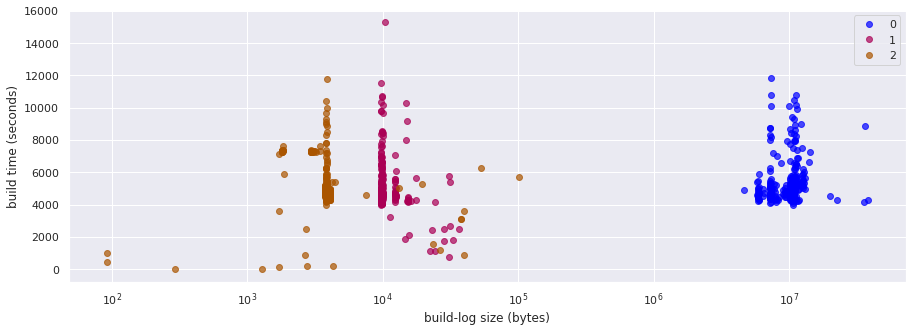

In [10]:
plot_clusters()

The scatter plot explains why it is hard to distinguish the two other clusters:

- the clustering algorithm has separated the two "columns" of successful builds in different clusters
- the failed builds that are scattered around the successful builds have been grouped together with one of them

Unfortunately, then, this initial clustering produced worse results than what we could obtain initially by just looking at log size and build duration.

Let's look closer at what happened here by taking a look at silhouette scoring.

We will run k-means with different numbers of clusters and plot the clusters' silhouette for each $k$:

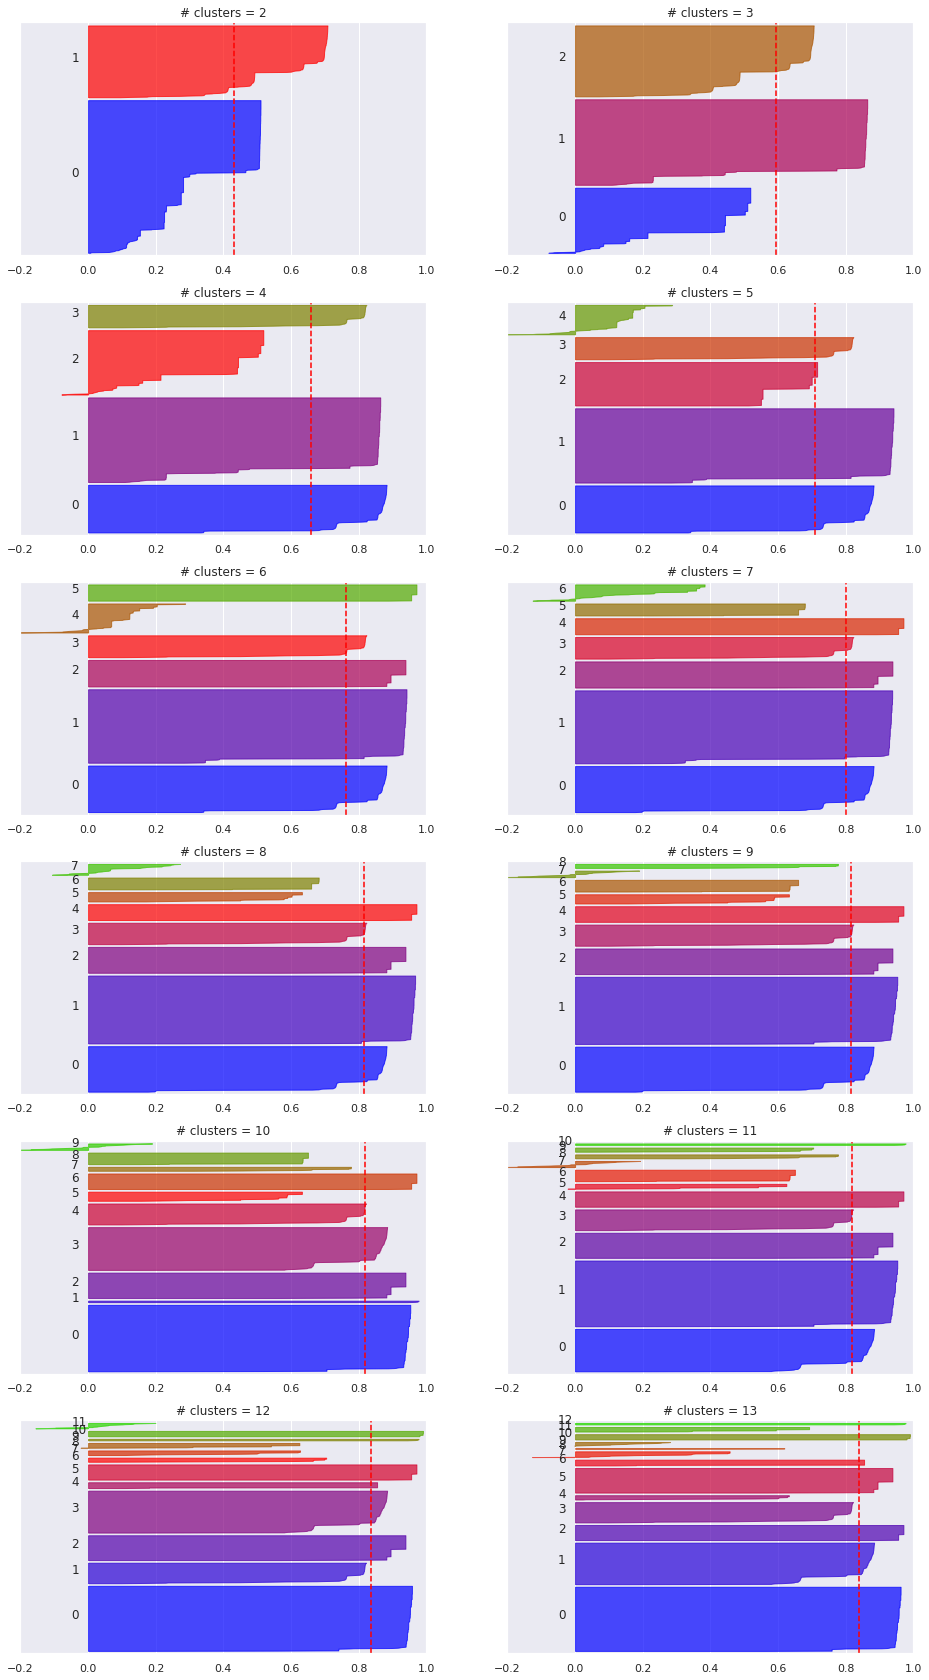

In [11]:
def kmeans_silhouette(x, kmax=13):
    cols = 2
    rows = int((kmax - 1) / cols)
    fig, axs = plt.subplots(rows, cols)
    ax = axs.flatten()
    fig.set_size_inches(cols * 8, rows * 5)
    for n, k in enumerate(range(2, kmax + 1)):
        # The silhouette coefficient can range from -1, 1 but all of our tests
        # lie within [-0.2, 1]
        ax[n].set_xlim([-0.2, 1])
        # The (k+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax[n].set_ylim([0, x.shape[0] + (k + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=k, random_state=123)
        cluster_labels = clusterer.fit_predict(x)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = metrics.silhouette_score(x, cluster_labels)
        # print(f"For {k} clusters the average silhouette_score is {silhouette_avg:.2f}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = metrics.silhouette_samples(x, cluster_labels)

        y_lower = 10
        for i in range(k):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[
                cluster_labels == i
            ]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = colormap(float(i) / k)
            ax[n].fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        # The vertical line for average silhouette score of all the values
        ax[n].axvline(x=silhouette_avg, color="red", linestyle="--")

        ax[n].set_title(f"# clusters = {k}")
        ax[n].set_yticks([])  # Clear the yaxis labels / ticks
        ax[n].set_xticks(np.arange(-0.2, 1.1, 0.2))


kmeans_silhouette(tfidf)

We picked $k=3$ based on the elbow method, but in the exploration of metrics for different numbers of clusters we can see that some higher number of clusters have some better scores.

Looking at the silhouette score in particular, we see that the average score increases as the number of clusters grows up to 8 clusters. In the silhouette plots above we can also observe that for $k>8$ the clustering appears to degrade (even if the average silhouette score remains relavively high)

The other metrics are also better with $k=8$ than $k=3$, so let's take a look of how does clustering look like when $k=8$:

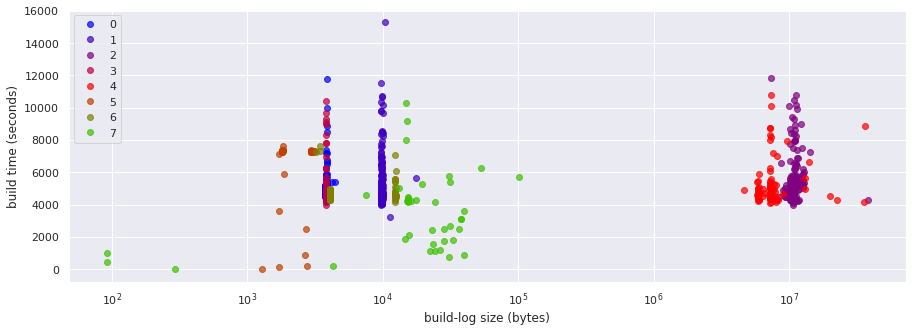

In [12]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(tfidf)
df = df.assign(cluster=kmeans.labels_)

plot_clusters()

On the positive side it seems that now we have the failed builds that scatter around successful ones properly separated in their own clusters. On the other hand, with 8 groups of build logs we appear to have excessive separation, in particular within the groups of failures with smaller log sizes.

It is not shown in this notebook to try to keep output reasonable, but an exploration of sample logs of these clusters does not seem to justify or explain why they would deserve separate clusters.

Whatt seems clear is that the clustering algorithm is being impacted by the fact that we have, at least, two types of formatting for the logs (both for successful and failed builds): as explained in the [initial build log EDA notebook](./build_log_EDA.ipynb), there was [a change in OpenShift CI tools](https://github.com/openshift/ci-tools/pull/1836) that caused a change in how build logs are formatted. This results in the "two columns of success" that we see in the visualization (different log contents, and therefore different log lenghts, for logs that would otherwise be almost identical), and it seems to be also impacting the clustering of failed logs.

Due to the impact of this change in log formatting, let's try our approach with logs that are a bit more consistently formatted.

## Avoiding the build log format change

Here we filter out all the build logs that were generated prior to the format change.

At the time of this writing, this means that we are removing a higher number of observations than the ones we keep. Moving forward though, all new builds use the new formatting, and therefore it seems more interesting to investigate the results that we can obtain with it.

In [13]:
# PR 1836 changed the way build logs are formatted
# https://github.com/openshift/ci-tools/pull/1836
# It was merged on 2021-04-05 16:45 UTC
pr_1836_merged = datetime(2021, 4, 5, 16, 45, tzinfo=timezone.utc)
pr_1836_timestamp = int(pr_1836_merged.timestamp())

df = df[df.start > pr_1836_timestamp]  # filter out old format logs
df = df.assign(cluster=df.result)
df

,result,size,start,end,duration,success,cluster
1380281977160077312,SUCCESS,3841,1617919845,1617929494,9649,True,SUCCESS
1385025333723402240,SUCCESS,3868,1619050750,1619056186,5436,True,SUCCESS
1379152673013501952,FAILURE,9212120,1617650599,1617655198,4599,False,FAILURE
1382952842423177216,SUCCESS,3838,1618556629,1618560934,4305,True,SUCCESS
1379871391536386048,FAILURE,10168121,1617821954,1617830667,8713,False,FAILURE
...,...,...,...,...,...,...,...
1380128512421138432,FAILURE,10251467,1617883260,1617889070,5810,False,FAILURE
1386942197940621312,FAILURE,10913264,1619507767,1619512517,4750,False,FAILURE
1384563411320311808,FAILURE,1830,1618940618,1618947972,7354,False,FAILURE
1381826019446493184,SUCCESS,3837,1618287973,1618292751,4778,True,SUCCESS


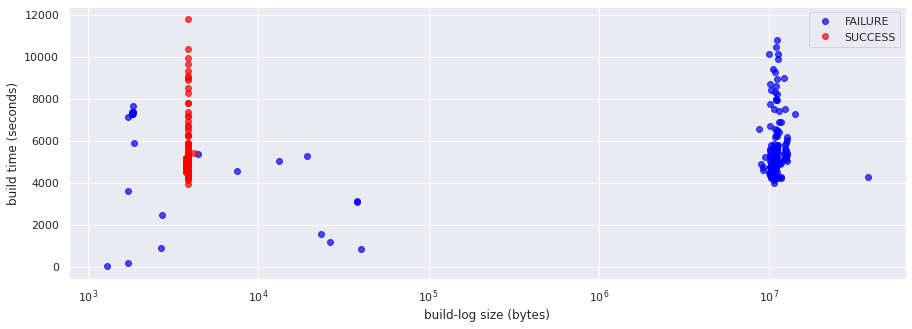

In [14]:
plot_clusters()

Here we have removed all the build logs prior to the format change. Obviously, our data size has decreased (less than a half at the time of this writing). But we don't have the "two columns of success" any more: all the successful builds have approximately the same size.

Let's rebuild our TF-IDF matrix by vectorizing these build logs only:

In [15]:
vectorizer = TfidfVectorizer(
    input="filename",
    min_df=0.05,
    token_pattern=token_pattern,
)

# Update the list of log files
build_logs = []
for build_id in df.index:
    build_logs.append(log_path_for(build_id))

t0 = time()
tfidf = vectorizer.fit_transform(build_logs)

print(f"Done in {time()-t0:.2f} seconds")
print(f"TF-IDF matrix: {tfidf.shape[0]} documents x {tfidf.shape[1]} terms")

Done in 53.21 seconds
TF-IDF matrix: 367 documents x 4169 terms


**NOTE**: we now have only a subset of the original documents, but we obtain more terms! How so?

This is becasue the threshold for terms to be considered based on the inverse document frequency is specified as a % of the number of documents (the `min_df` parameter). Due to the change in the dataset size, the absolute number has changed.

Let's take a look at the metrics and silhouettes of various numbers of clusters for this new data:

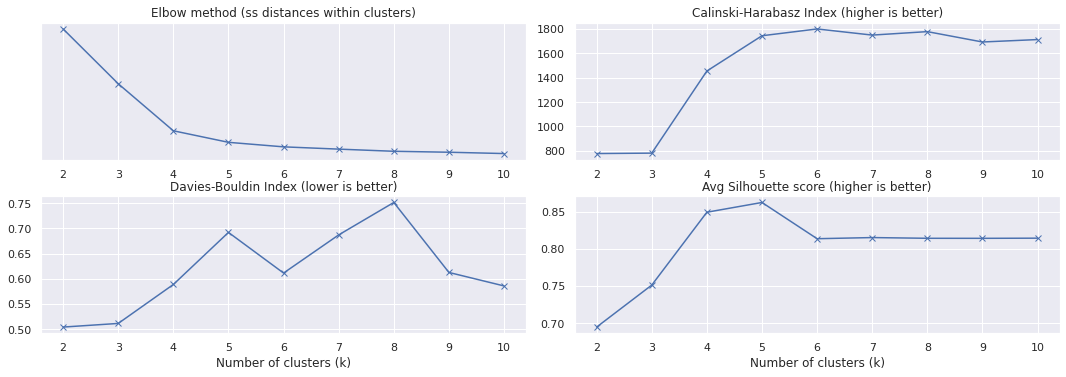

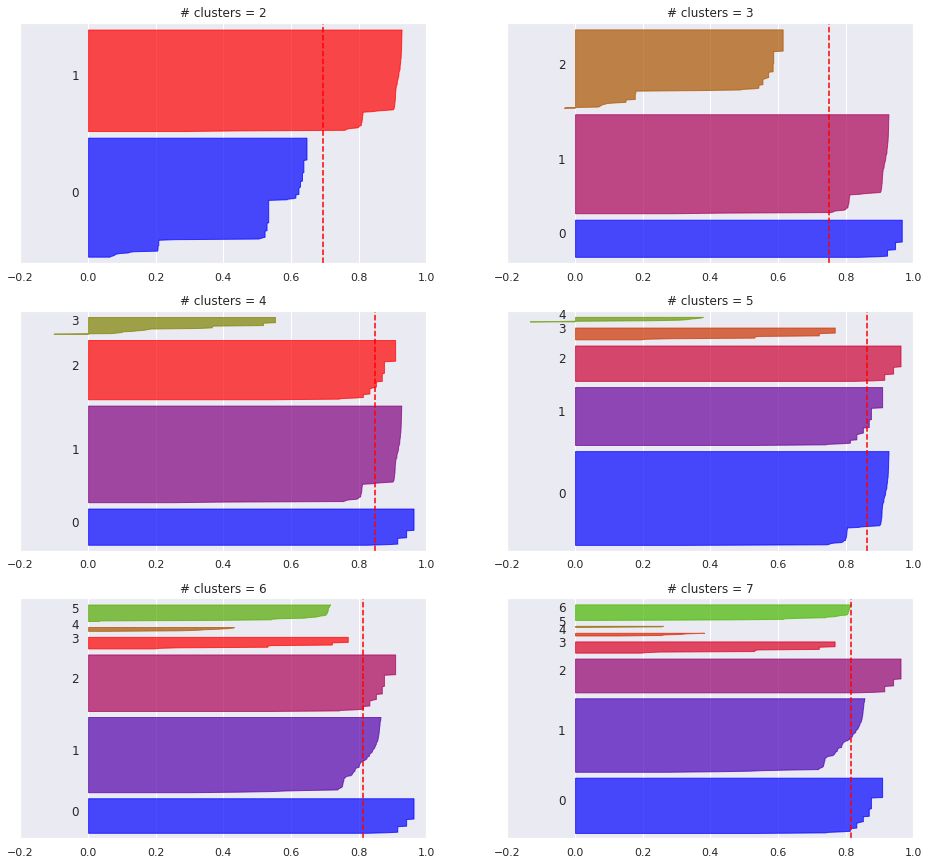

In [16]:
kmeans_metrics(tfidf)
kmeans_silhouette(tfidf, kmax=7)

The elbow plot suggests that we should pick $k=4$.

This time, the rest of the metrics agree that this is a good pick:

4 clusters with the following metrics:
  - Silhouette coefficient: 0.85
  - Calinski-Harabasz index: 1453.79
  - Davies-Bouldin index: 0.59
A list of the most common terms in each cluster:
Cluster 0: e2e step running after succeeded ipi-conf release for openshift-e2e-test
Cluster 1: apr suite openshift/conformance/parallel k8s should volumes sig-storage driver testpattern
Cluster 2: step running after succeeded release for e2e-gcp latest https
Cluster 3: failed release acquire to for error latest not https


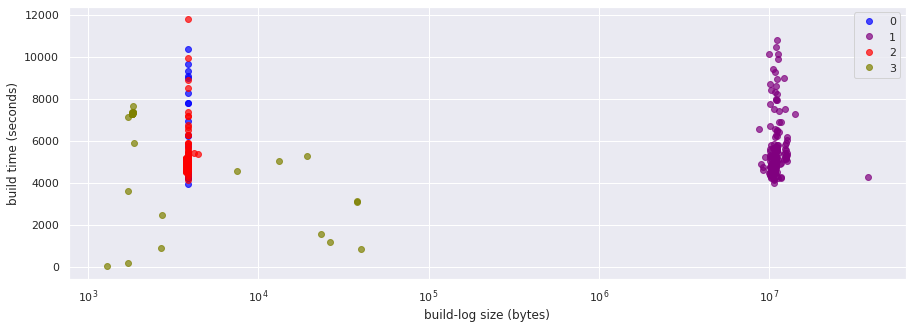

In [17]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(tfidf)
df = df.assign(cluster=kmeans.labels_)

describe_clusters()
plot_clusters()

This looks much better than our previous initial attempt: the 4 clusters do seem to match and capture the types of builds that we have, clearly separating two different sets of failures - and also grouping the successfuld builds in two different clusters.

The top terms for each cluster make sense and match with the grouping, but they don't provide enough hints to help us understand the two groups of successful builds.

To dig a bit further on this classification, let's look at one samble job run from each of the groups:

In [18]:
def tail_log(build_id, amount=1500):
    """Prints the last few lines of build_id's build log file.
    The amount to read is in bytes."""
    path = log_path_for(build_id)
    size = os.path.getsize(path)
    print(f">> BUILD {build_id}. Log length: {size} bytes")
    print(f">> BUILD URL: {prow_url_for(build_id)}\n")
    with open(path) as f:
        if size > amount:
            f.seek(size - amount)
        lines = f.readlines()
    for line in lines[1:]:  # skip the first line as it's probably incomplete
        print(line, end="")


for cluster in range(k):
    print("\n>> Sample job run of type", cluster)
    tail_log(df[df.cluster == cluster].sample(random_state=123).index.item())


>> Sample job run of type 0
>> BUILD 1380947233955909632. Log length: 3835 bytes
>> BUILD URL: https://prow.ci.openshift.org/view/gcs/origin-ci-test/logs/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp/1380947233955909632

INFO[2021-04-10T18:51:16Z] Running step e2e-***-openshift-e2e-test.     
INFO[2021-04-10T19:22:46Z] Step e2e-***-openshift-e2e-test succeeded after 31m30.061462427s. 
INFO[2021-04-10T19:22:46Z] Running step e2e-***-gather-core-dump.       
INFO[2021-04-10T19:23:16Z] Step e2e-***-gather-core-dump succeeded after 30.12392026s. 
INFO[2021-04-10T19:23:16Z] Running step e2e-***-gather-***-console.     
INFO[2021-04-10T19:24:06Z] Step e2e-***-gather-***-console succeeded after 50.062247974s. 
INFO[2021-04-10T19:24:06Z] Running step e2e-***-gather-must-gather.     
INFO[2021-04-10T19:27:26Z] Step e2e-***-gather-must-gather succeeded after 3m20.066930755s. 
INFO[2021-04-10T19:27:26Z] Running step e2e-***-gather-extra.           
INFO[2021-04-10T19:29:27Z] Step e2e-***-g

In the content of the logs we do see now what makes the difference between the two types of successful logs: one group has the cloud provider (e.g. *gcp*) obfuscated with asterisks (\*). A significant number of occurrences of this difference appear in each log. And remember that the size of the build logs on these two clusters (both successful runs) are relatively short, which means that this difference does make the log files different enough.

### Another format change: asterisks

Based on the observation above, let's try one additional data clean up: we will investigate what happens if we modify our tokenizer to accept askerisks as part of the terms, so that for example both of these are considered a term: `e2e-gcp-gather-extra` and `e2e-***-gather-extra` (that last one was two separate tokens in our previous data: `e2e` and `gather-extra`).

Moreover, this time we will try to apply some domain knowledge, or at least some intuition, to pick the number of clusters, instead of relying on metrics (at least initially). Let's assume here that we want to be able to differenciate, just by looking at build logs, three types of builds:

- successful builds
- builds that fail because some tests fail
- builds that fail due to preparatory / infrastructure steps

So, we will look at the case of $k=3$.

We saw in the initial attempt with $k=3$ that the clusters were badly mixing successful builds with builds that failed in preparatory steps.

But then we cleaned the data set a bit by removing different output types and sticking to the current output format. Has this change in the data improved the classification within 3 clusters?

3 clusters with the following metrics:
  - Silhouette coefficient: 0.75
  - Calinski-Harabasz index: 781.93
  - Davies-Bouldin index: 0.51
A list of the most common terms in each cluster:
Cluster 0: e2e step running after succeeded ipi-conf release for openshift-e2e-test
Cluster 1: apr suite openshift/conformance/parallel k8s should volumes sig-storage driver testpattern
Cluster 2: step running after succeeded release for latest e2e-gcp to


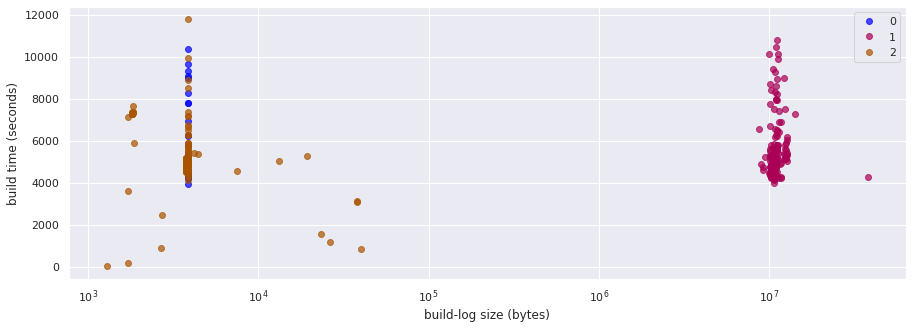

In [19]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(tfidf)
df = df.assign(cluster=kmeans.labels_)

describe_clusters()
plot_clusters()

We see that no, removing the old-format build logs does not seem to have improved the classification within these 3 types of builds much: we have a group that misxes successful builds with fail-during-preparation builds.

Ok then, let's see if the additional "cleaning" step that we wanted to do (i.e. to accep asterisks within terms) helps us improve that:

3 clusters with the following metrics:
  - Silhouette coefficient: 0.80
  - Calinski-Harabasz index: 1350.32
  - Davies-Bouldin index: 0.71
A list of the most common terms in each cluster:
Cluster 0: step running after succeeded release for latest e2e-gcp e2e-***-ipi-conf
Cluster 1: apr suite openshift/conformance/parallel k8s should volumes sig-storage driver testpattern
Cluster 2: failed release acquire to for error latest not https


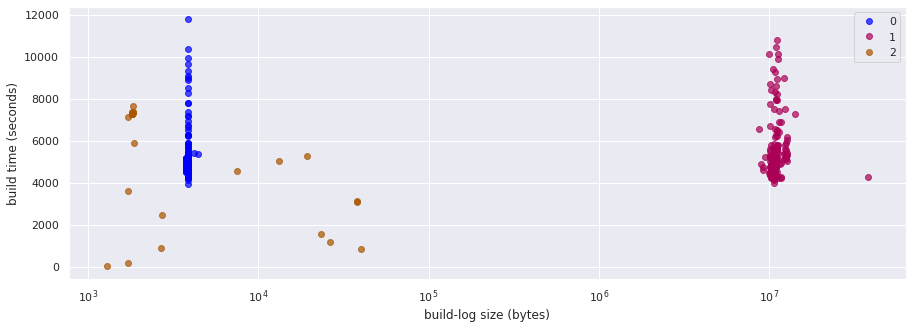

In [20]:
token_pattern = r"\b[a-z][a-z0-9_/\.*-]+\b"  # Accept '*' as part of a token

vectorizer = TfidfVectorizer(input="filename", min_df=0.05, token_pattern=token_pattern)
tfidf = vectorizer.fit_transform(build_logs)

kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(tfidf)
df = df.assign(cluster=kmeans.labels_)

describe_clusters()
plot_clusters()

Great! It turns out that after fine-tuning the tokenizer by accepting terms with asterisks, the clustering algorithm produces 3 groups that match our initial intuition/expectation.

This suggests that this is a better tokenization approach.

Let's look at this cleaner data a bit more though: we see that the metrics we obtain are a bit lower than our previous clustering attempt. How do the metrics look now, with this new tokenization, for various number of clusters?

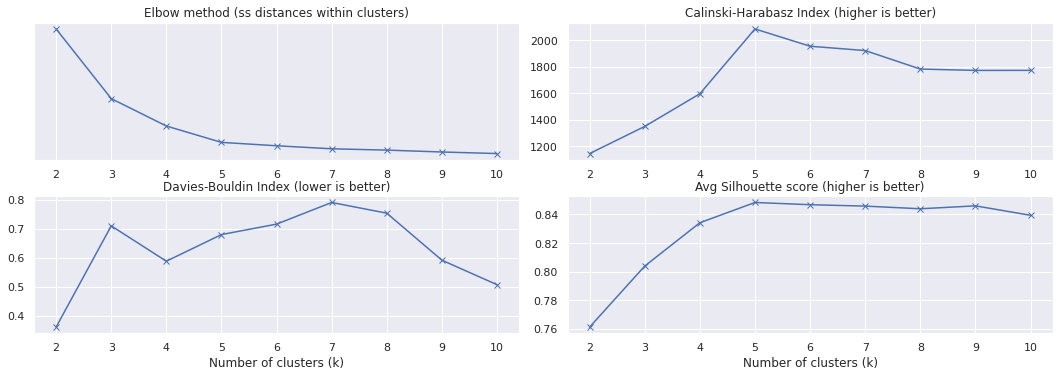

In [21]:
kmeans_metrics(tfidf)

While we see an elbow at $k=3$, there is also a softer elbow in $k=5$.

And the average Silhouette score and the Calinski-Harabasz index are clearly better for $k=5$

So, what do we get if we clusterize these vectors with 5 clusters?

5 clusters with the following metrics:
  - Silhouette coefficient: 0.85
  - Calinski-Harabasz index: 2085.61
  - Davies-Bouldin index: 0.68
A list of the most common terms in each cluster:
Cluster 0: apr suite openshift/conformance/parallel k8s should volumes sig-storage driver testpattern
Cluster 1: step running after succeeded release for e2e-gcp latest https
Cluster 2: acquire release failed for to latest steps https not
Cluster 3: step running after succeeded e2e-***-ipi-conf release for e2e-***-openshift-e2e-test e2e-***-ipi-install-rbac
Cluster 4: error level msg info failed the to is step


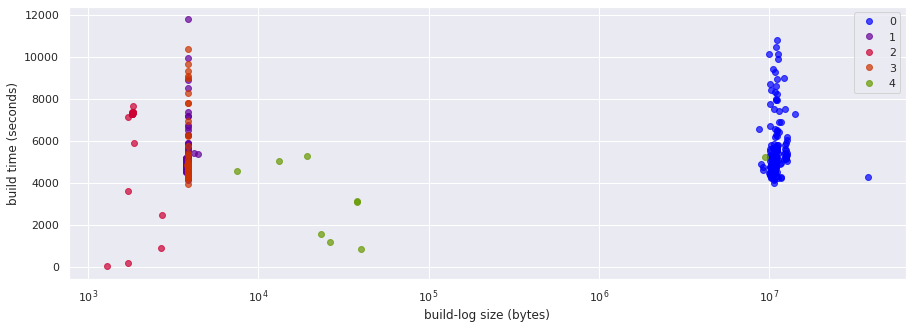

In [22]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(tfidf)
df = df.assign(cluster=kmeans.labels_)

describe_clusters()
plot_clusters()

On one hand, we see that we still get the successful builds split in two groups, and according to their top terms it is clear that we are still coping with askerisk obfuscation - which is not too surprising.

But we also have 3 different groups for builds that fail. One of them is clearly the test-related failures. What about the other two? Let's get sample log output from each of the groups to try to interpret the different groups better:

In [23]:
for cluster in range(k):
    print("\n>> Sample job run of type", cluster)
    tail_log(df[df.cluster == cluster].sample(random_state=123).index.item())


>> Sample job run of type 0
>> BUILD 1379803403793731584. Log length: 10141089 bytes
>> BUILD URL: https://prow.ci.openshift.org/view/gcs/origin-ci-test/logs/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp/1379803403793731584

ERRO[2021-04-07T15:53:31Z] Failing tests:                               
ERRO[2021-04-07T15:53:31Z] [sig-instrumentation][Late] Alerts shouldn't report any alerts in firing or pending state apart from Watchdog and AlertmanagerReceiversNotConfigured and have no gaps in Watchdog firing [Suite:openshift/conformance/parallel] 
ERRO[2021-04-07T15:53:31Z] Writing JUnit report to /logs/artifacts/junit/junit_e2e_20210407-153952.xml 
ERRO[2021-04-07T15:53:31Z] error: 3 fail, 1113 pass, 1609 skip (25m56s) 
ERRO[2021-04-07T15:53:31Z] ++ date +%s                                  
ERRO[2021-04-07T15:53:31Z] + echo 1617809992                            
ERRO[2021-04-07T15:53:31Z] {"component":"entrypoint","error":"wrapped process failed: exit status 1","file":"prow/entryp

Looking at these sample logs suggests that by tokenizing with our latest pattern and clustering in 5 clusters we can identify these 5 groups of builds:

1. failures due to some test(s)
2. successful builds without provider obfuscation
3. failures in CI infrastructure (e.g. lack of capacity)
4. successful builds with provider obfuscation
5. failures during preparation steps, before tests can be executed

That is hopefully a useful grouping, and it certainly does provide additional details beyond what can be deduced just from the log size and duration.

Finally, as the vocabulary of terms that we have worked with seems to work reasonably well for this task, we will keep a copy of it in case it is useful for other tasks that can benefit from a base vocabulary:

In [24]:
vocab_path = "../../../../data/processed/build-logs/"
vocab_file_name = os.path.join(vocab_path, f"{job_name}_vocabulary.txt")

with open(vocab_file_name, "w") as f:
    f.writelines("\n".join(vectorizer.get_feature_names()))

# Conclusion

This notebook applies a clustering algorithm to job runs based on the term freqency within their build logs. This clustering does a decent job at grouping job runs according to their type of failure (e.g. test failure vs infrastructure problem or installer failure). This shows that content analysis does provide additional insight over just plain metadata (size and duration).

An important additional observation from this notebook is actually before the clustering task: we discuss how *inverse document frequency (IDF)* can help us in log parsing in the context of CI logs: the fact that we have multiple occurrences of the same log file can aid us at distinguishing unique values (like a generated Pod name) from a more constant part (like a Deployment name), something that standard log parsing approaches would struggle with.

## Summary

- A bag-of-words technique, TF-IDF, can be successfully applied to CI logs
  - in that context, tuning parameters like min_df can help in the log parsing task
- Log formatting has an impact in the effectiveness of the downstram task
  - A log format change in PR 1836 sill has a significant impact despite our approach
  - Along those lines: the difference in step naming ("e2e-gcp vs "e2e-*") also as an impact
- The choice of which token pattern to use is important

## Next steps

- (maybe?) try tokenizing more aggressively and add n-grams as terms.
- improve the clustering method by trying a different clustering algorithm/approach
  - other clustering algorithms like dbscan or hierarchical clustering
  - dimensionality reduction prior to clustering
  - a clustering algorithm that is more robust under high dimensionality (i.e. not euclidean distance based)
- attempt to apply a log parser (e.g. Drain) before the vectorizer.
- explore other NLP techniques like [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html)
- dig on using IDF to aid in vocabulary building for further analysis